# 🏡 İstanbul Konut Verileri ile Geliştirilmiş Akıllı Emlak Analiz Sistemi

⭐ Bu proje *`Akbank Makine Öğrenmesine Giriş Bootcamp`* kapsamında geliştirilmiştir.

## 🎯 Proje Amacı
Bu projenin temel amacı, İstanbul’daki konut ilanlarını içeren kapsamlı ve gerçek bir veri seti üzerinden, yapay zeka destekli analiz araçları geliştirmektir. Kullanıcıların konut piyasasıyla ilgili daha bilinçli kararlar almasını sağlamak amacıyla, aynı veri setinden faydalanarak dört farklı makine öğrenmesi modeli geliştirilmiştir. Bu modeller, büyük dil modelleri (LLM) ile entegre edilecek, kullanıcıların veriyle doğal dil aracılığıyla etkileşime geçebileceği bir sistem oluşturulacaktır.

## 📊 Veri Seti Hakkında
Veri seti, Kaggle platformu üzerinden erişilebilen, İstanbul'daki satılık konutlara ait ilanlardan oluşmaktadır. Türkiye’nin en büyük ilan sitesinden Python 🐍 (requests ve BeautifulSoup) kullanılarak toplanmış ve ham haliyle paylaşılmıştır. Yaklaşık 25.000 ilan ve 38 değişken içeren bu veri seti, konutların konumu, fiyatı, fiziksel özellikleri, yatırım uygunluğu, kredi kullanılabilirliği gibi birçok önemli bilgiyi barındırmaktadır.

## 🧠 Geliştirilen Modeller
### `💰 Ev Fiyat Tahmini (Regresyon Modeli)`
Konutun fiziksel ve konumsal özelliklerine göre tahmini satış fiyatı üretir. Kullanıcı, bir evin temel bilgilerini girerek piyasa değerini yaklaşık olarak öğrenebilir.

### `🚨 Anomali Tespiti (Outlier Detection)`
Veride yer alan olağandışı veya tutarsız değerleri tespit eder. Bu model sayesinde, fiyat açısından aşırı düşük ya da yüksek, şüpheli ilanlar belirlenebilir.

### `🏘️ Ev Tipi Kümelemesi (Clustering)`
Konutları benzer özelliklerine göre gruplara ayırarak veri içindeki örüntüleri ortaya çıkarır. Piyasa segmentasyonu ve kullanıcıya uygun ev türlerinin belirlenmesi için kullanılır.

### `📈 Yatırıma Uygunluk Sınıflandırması (Classification)`
İlan verilerine bakarak, bir evin “yatırıma uygun” olup olmadığını sınıflandırır. Özellikle yatırım amaçlı alım yapmak isteyen kullanıcılar için geliştirilmiştir.

In [ ]:
# Temel Kütüphaneler
import pandas as pd
import numpy as np
import re
import pickle

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Model Seçimi ve Değerlendirme
from sklearn.model_selection import (
    train_test_split, ShuffleSplit, 
    cross_val_score,RandomizedSearchCV
)
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix,
    make_scorer, f1_score, silhouette_score,ConfusionMatrixDisplay
)

# Ön İşleme
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

# Regresyon Modelleri
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Sınıflandırma Modelleri
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Anomali Tespiti
from sklearn.ensemble import IsolationForest

# Kümeleme ve Boyut İndirgeme
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

# Süre Ölçümü için
import time

**Temel veri işleme:** pandas, numpy, re, pickle  
**Görselleştirme:** matplotlib, seaborn  
**Model seçimi ve değerlendirme:** sklearn.model_selection, sklearn.metrics  
**Ön işleme:** StandardScaler, LabelEncoder, Pipeline  
**Regresyon modelleri:** Ridge, LinearRegression, RandomForestRegressor, XGBRegressor, vb.  
**Sınıflandırma modelleri:** LogisticRegression, RandomForestClassifier, SVC, XGBClassifier, vb.  
**Anomali tespiti:** IsolationForest  
**Kümeleme ve boyut indirgeme:** KMeans, PCA

# 1-Keşifsel Veri Analizi & Veri Ön İşleme

In [163]:
data = pd.read_csv("dataset/house-price-dataset/HouseData.csv")
df = data.drop_duplicates()

df.head()

,Unnamed: 0,district,price,address,AdUpdateDate,Category,GrossSquareMeters,BuildingAge,NumberFloorsofBuilding,UsingStatus,...,PriceStatus,RentalIncome,NumberOfBalconies,BalconyType,HallSquareMeters,WCSquareMeters,IsItVideoNavigable?,Subscription,BathroomSquareMeters,BalconySquareMeters
0,0,adalar,"3,100,000TL","['Anasayfa', 'Satılık Daire', 'İstanbul Satılı...",24 Şubat 2022,Satılık,160 m2,21 Ve Üzeri,3,Mülk Sahibi Oturuyor,...,Genel Fiyat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,adalar,"1,600,000TL","['Anasayfa', 'Satılık Daire', 'İstanbul Satılı...",02 Mart 2022,Satılık,120 m2,5-10,3,Mülk Sahibi Oturuyor,...,Genel Fiyat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,adalar,"18,500,000TL","['Anasayfa', 'Satılık Müstakil Ev', 'İstanbul ...",11 Şubat 2022,Satılık,350 m2,21 Ve Üzeri,2,Mülk Sahibi Oturuyor,...,Genel Fiyat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,adalar,"9,500,000TL","['Anasayfa', 'Satılık Bina', 'İstanbul Satılık...",11 Şubat 2022,Satılık,550 m2,11-15,3,Mülk Sahibi Oturuyor,...,Genel Fiyat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,adalar,"25,000,000TL","['Anasayfa', 'Satılık Köşk', 'İstanbul Satılık...",19 Ocak 2022,Satılık,840 m2,21 Ve Üzeri,4,Boş,...,Genel Fiyat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Veri CSV dosyasından okunuyor  
- Tekrar eden satırlar kaldırılıyor  
- İlk 5 satır görüntüleniyor

In [164]:
data.columns

Index(['Unnamed: 0', 'district', 'price', 'address', 'AdUpdateDate',
       'Category', 'GrossSquareMeters', 'BuildingAge',
       'NumberFloorsofBuilding', 'UsingStatus', 'EligibilityForInvestment',
       'BuildStatus', 'TitleStatus', 'ItemStatus', 'NumberOfBathrooms',
       'NumberOfWCs', 'AdCreationDate', 'Type', 'NetSquareMeters',
       'NumberOfRooms', 'FloorLocation', 'HeatingType', 'CreditEligibility',
       'InsideTheSite', 'StructureType', 'MortgageStatus', 'Swap', 'Balcony',
       'PriceStatus', 'RentalIncome', 'NumberOfBalconies', 'BalconyType',
       'HallSquareMeters', 'WCSquareMeters', 'IsItVideoNavigable?',
       'Subscription', 'BathroomSquareMeters', 'BalconySquareMeters'],
      dtype='object')

- Veri setindeki sütun isimleri listeleniyor

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25155 entries, 0 to 25154
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                25155 non-null  int64 
 1   district                  25155 non-null  object
 2   price                     25155 non-null  object
 3   address                   25155 non-null  object
 4   AdUpdateDate              25155 non-null  object
 5   Category                  25155 non-null  object
 6   GrossSquareMeters         25155 non-null  object
 7   BuildingAge               25155 non-null  object
 8   NumberFloorsofBuilding    25155 non-null  int64 
 9   UsingStatus               25155 non-null  object
 10  EligibilityForInvestment  21506 non-null  object
 11  BuildStatus               11231 non-null  object
 12  TitleStatus               9712 non-null   object
 13  ItemStatus                18332 non-null  object
 14  NumberOfBathrooms     

- Veri setindeki sütun isimleri, veri tipleri ve non-null değerler listelenir.

In [166]:
df.isnull().sum()

Unnamed: 0                      0
district                        0
price                           0
address                         0
AdUpdateDate                    0
Category                        0
GrossSquareMeters               0
BuildingAge                     0
NumberFloorsofBuilding          0
UsingStatus                     0
EligibilityForInvestment     3649
BuildStatus                 13924
TitleStatus                 15443
ItemStatus                   6823
NumberOfBathrooms               0
NumberOfWCs                 17026
AdCreationDate                  0
Type                            0
NetSquareMeters                 0
NumberOfRooms                   0
FloorLocation                   0
HeatingType                     0
CreditEligibility               0
InsideTheSite                   0
StructureType               14749
MortgageStatus              19097
Swap                         4316
Balcony                     16046
PriceStatus                     0
RentalIncome  

- Veri setindeki boş değer sayıları listelendi.
- Önemli ölçüde boş değer bulunduğu gözlemlendi.

In [167]:
df = df.drop(['Unnamed: 0', 'address', 'AdUpdateDate', 'Category',
       'BuildingAge', 'NumberFloorsofBuilding', 'UsingStatus', 'EligibilityForInvestment',
       'BuildStatus', 'TitleStatus', 'NumberOfBathrooms', 'NumberOfWCs', 
       'AdCreationDate', 'Type', 'NetSquareMeters', 'FloorLocation', 'HeatingType', 
       'CreditEligibility', 'InsideTheSite', 'StructureType', 'MortgageStatus', 
       'Swap', 'Balcony', 'PriceStatus', 'RentalIncome', 'NumberOfBalconies', 
       'BalconyType', 'HallSquareMeters', 'WCSquareMeters', 'IsItVideoNavigable?',
       'Subscription', 'BathroomSquareMeters', 'BalconySquareMeters'], axis = "columns")
df.head()

,district,price,GrossSquareMeters,ItemStatus,NumberOfRooms
0,adalar,"3,100,000TL",160 m2,Eşyalı,3+1
1,adalar,"1,600,000TL",120 m2,Eşyalı,2+1
2,adalar,"18,500,000TL",350 m2,Boş,3+1
3,adalar,"9,500,000TL",550 m2,NaN,8+ Oda
4,adalar,"25,000,000TL",840 m2,NaN,8+ Oda


- Geliştirilmesi planlanan uygulamada kullanıcıların kolayca erişebileceği `İlçe`, `Fiyat`, `Brüt Metrekare`, `Eşya Durumu` ve `Oda Sayısı` gibi temel verilere odaklanılabilmesi amacıyla, analiz sürecinde gereksiz veya kullanılmayacak sütunlar veri setinden çıkarılmıştır.

In [168]:
df.isnull().sum()

district                0
price                   0
GrossSquareMeters       0
ItemStatus           6823
NumberOfRooms           0
dtype: int64

- ItemStatus (Eşyalı,Boş) sütununda 6823 eksik veri listeleniyor

In [169]:
dist_rate = df.ItemStatus.value_counts(normalize = True)
dist_rate

ItemStatus
Boş       0.954124
Eşyalı    0.045876
Name: proportion, dtype: float64

- `ItemStatus` sütunundaki sınıfların oranları (yüzdelik dağılımı) hesaplanıyor

## 1.1-Eksik Değerler

In [170]:
missing = df['ItemStatus'].isnull()
df.loc[missing, 'ItemStatus'] = np.random.choice(dist_rate.index, size = len(df[missing]), p = dist_rate.values)

- `ItemStatus` sütunundaki eksik değerler tespit ediliyor  
- Eksik değerler, mevcut sınıf dağılımına göre rastgele dolduruluyor

In [171]:
df.isnull().sum()

district             0
price                0
GrossSquareMeters    0
ItemStatus           0
NumberOfRooms        0
dtype: int64

- Eksik değerlerin olmadığı gözlemleniyor

## 1.2-Kategorik Dağılımlar

In [172]:
def plot_categorical_distribution(df, column, figsize=(15, 8), palette='viridis', title=None):
    plt.figure(figsize=figsize)

    counts = df[column].value_counts().sort_values(ascending=False)
    df_counts = counts.reset_index()
    df_counts.columns = [column, 'Count']

    ax = sns.barplot(
        data=df_counts,
        x='Count',
        y=column,
        hue=column,
        palette=palette,
        dodge=False,
        legend=False
    )
    ax.bar_label(ax.containers[0])

    if title is None:
        title = f"{column} Dağılımı"

    plt.title(title)
    plt.xlabel("Adet")
    plt.ylabel(f"{column} Sayısı")
    plt.tight_layout()
    plt.show()

- Kategorik bir sütunun dağılımını yatay çubuk grafik ile görselleştirmek için kullanılam fonksiyon
- Farklı değişkenlerin dağılımını görmek için kullanılacak.

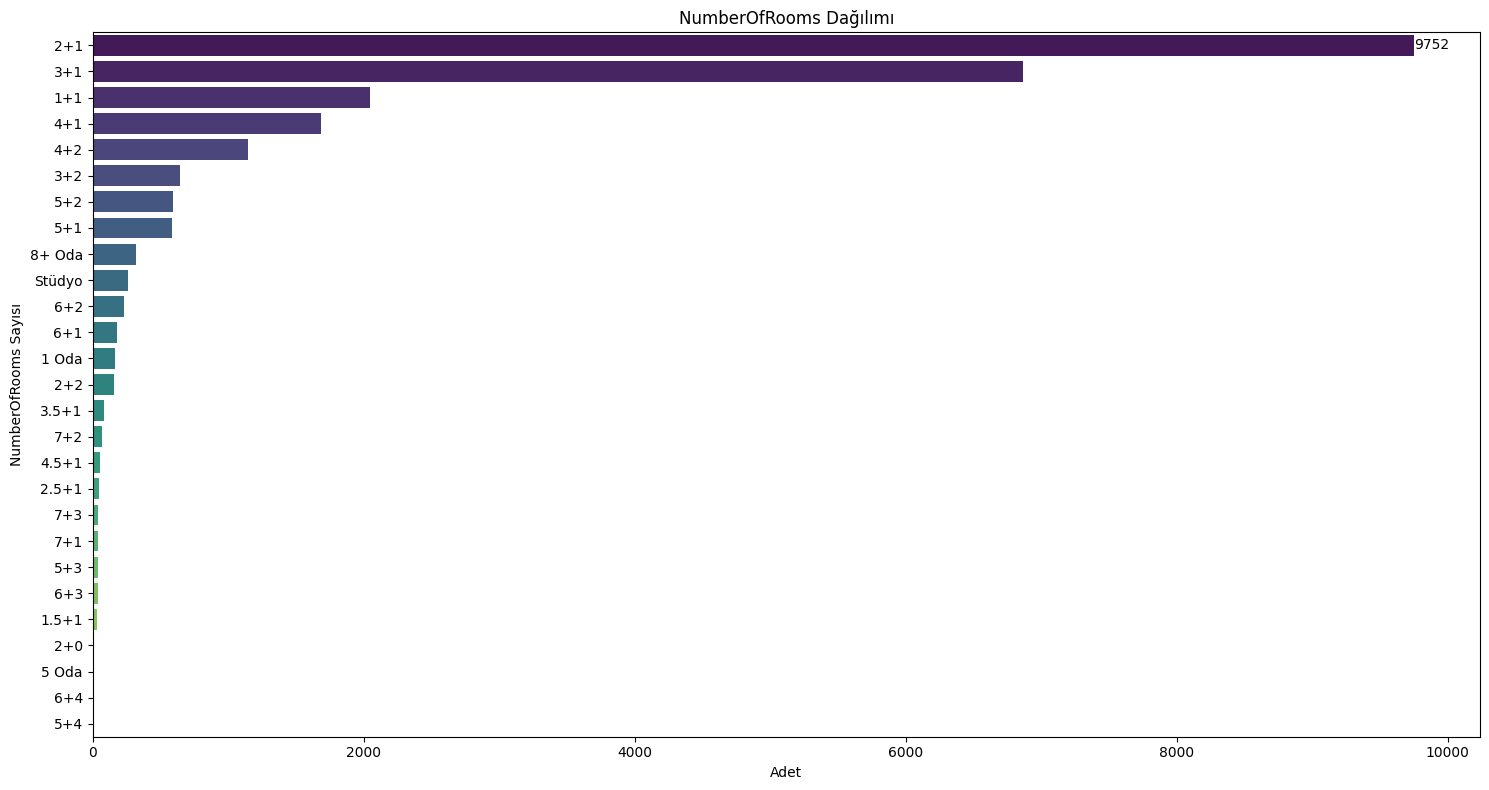

In [173]:
plot_categorical_distribution(df, 'NumberOfRooms')

- Oda/Salon dağılımı, yukarıda sunulan grafikte gösterildiği üzere dengeli bir dağılım sergilememektedir. Yapılan gözlemler sonucunda, `2+1` ve `3+1` daire tiplerinin diğer sınıflara kıyasla belirgin şekilde daha fazla sayıda olduğu tespit edilmiştir.

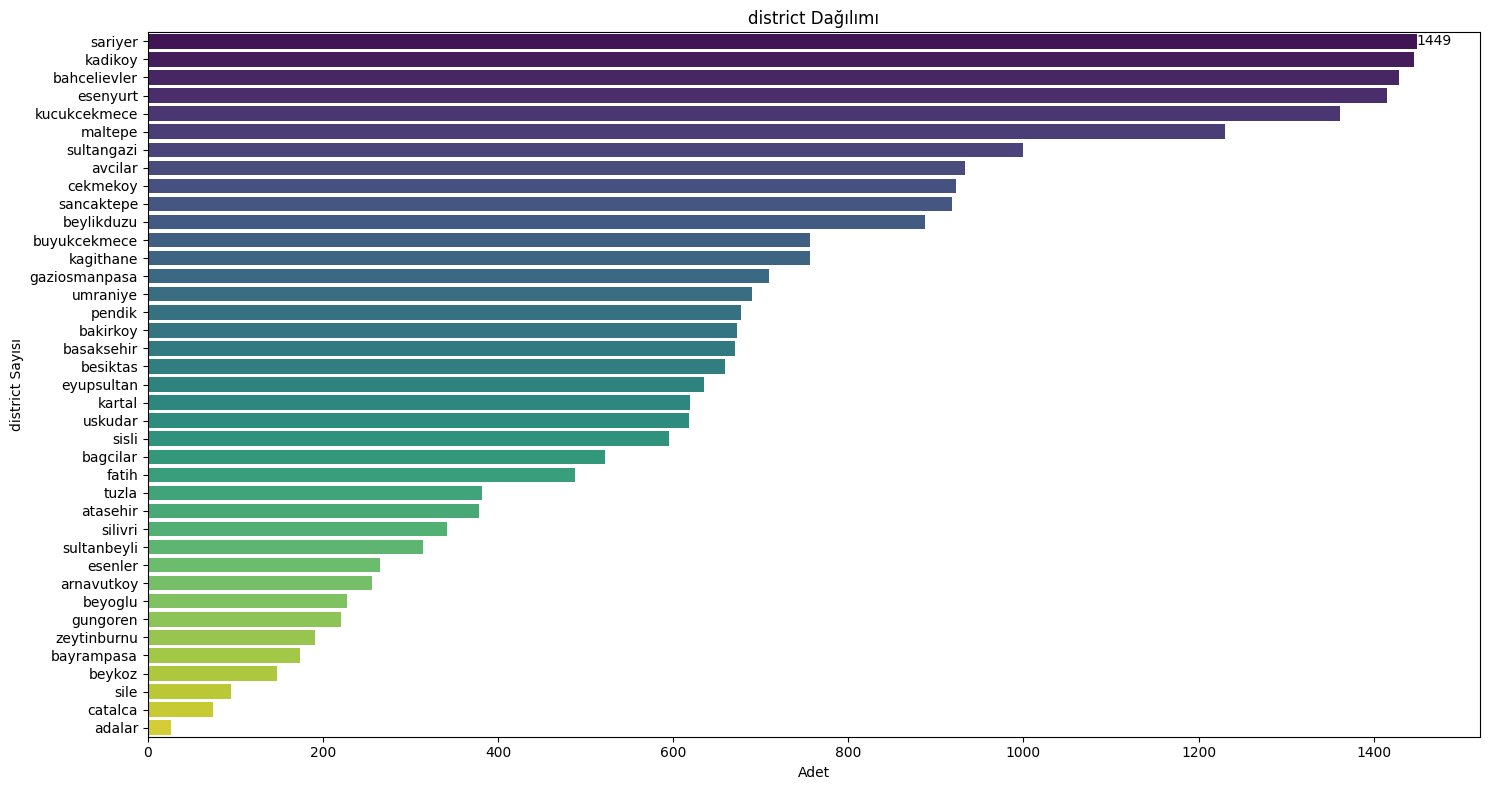

In [174]:
plot_categorical_distribution(df, 'district')

- İlçelerin dağılımı da dengeli bir dağılım sergilememektedir. En çok örnek `Sarıyer`'de yer alırken en az örnek `Adalar`'da yer almaktadır.

## 1.3-Veri Temizliği

In [175]:
df.dtypes

district             object
price                object
GrossSquareMeters    object
ItemStatus           object
NumberOfRooms        object
dtype: object

- Tüm veri tipleri şuanda object olarak görülmekte. Sayısal değerler için dönüşüm yapılmalı
- `price`, `GrossSquareMeters` ve `NumberOfRooms` sayısal değerlerde olmalı.

In [176]:
df["price"].unique()

array(['3,100,000TL', '1,600,000TL', '18,500,000TL', ..., '22,260,000TL',
       '43,280,000TL', '12,000,000TLarrow_downward%25'], dtype=object)

- `price` sütunundaki benzersiz değerler listelenir 
- Bazı değerlerin sonlarında geçersiz karakterler (örneğin `%`, `arrow_downward`) bulunuyor

In [177]:
df["GrossSquareMeters"].unique()

array(['160 m2', '120 m2', '350 m2', '550 m2', '840 m2', '200 m2',
       '400 m2', '250 m2', '360 m2', '180 m2', '125 m2', '140 m2',
       '260 m2', '500 m2', '430 m2', '130 m2', '75 m2', '682 m2',
       '2.250 m2', '100 m2', '90 m2', '85 m2', '105 m2', '225 m2',
       '95 m2', '330 m2', '220 m2', '190 m2', '170 m2', '600 m2',
       '303 m2', '194 m2', '185 m2', '210 m2', '55 m2', '175 m2', '70 m2',
       '300 m2', '115 m2', '285 m2', '700 m2', '1.000 m2', '80 m2',
       '110 m2', '107 m2', '135 m2', '272 m2', '844 m2', '128 m2',
       '204 m2', '352 m2', '650 m2', '590 m2', '84 m2', '132 m2',
       '325 m2', '111 m2', '102 m2', '271 m2', '60 m2', '145 m2',
       '310 m2', '196 m2', '240 m2', '150 m2', '850 m2', '195 m2',
       '701 m2', '98 m2', '155 m2', '3.001 m2', '320 m2', '87 m2',
       '89 m2', '83 m2', '186 m2', '168 m2', '705 m2', '236 m2', '65 m2',
       '158 m2', '97 m2', '45 m2', '228 m2', '127 m2', '117 m2', '173 m2',
       '73 m2', '136 m2', '146 m2', '1.106

- `GrossSqueareMeters` sütunundaki m2 ifadeleri temizlenmeli

In [178]:
df["NumberOfRooms"].unique()

array(['3+1', '2+1', '8+ Oda', '3+2', '5+1', '5 Oda', '2+2', '7+3', '1+1',
       '5+3', '1 Oda', '6+1', '4+2', '5+2', '4+1', '6+2', '6+3', '2.5+1',
       'Stüdyo', '6+4', '7+1', '1.5+1', '2+0', '7+2', '3.5+1', '4.5+1',
       '5+4'], dtype=object)

- `NumberOfRooms` sütununda veri dönüşümüne ihtiyaç duyulduğu gözlemleniyor. 3+1 gibi ifadelerin numerik hale getirilmesi gerekiyor.

In [179]:
def clear_and_convert_number(value, col_name):
    # Değeri string olarak al, başındaki ve sonundaki boşlukları kaldır ve küçük harfe çevir
    value_str = str(value).strip().lower()
    
    # 'm2' veya 'm²' gibi alan birimlerini stringden çıkar
    value_str = re.sub(r'm2|m²', '', value_str)
    
    # String içinde sayıya ait rakam, nokta ve virgülleri yakala
    num_str = re.findall(r'[\d.,]+', value_str)
    if not num_str:
        # Sayı bulunmazsa NaN döndür
        return np.nan
    num_str = num_str[0]
    
    # Virgül ve noktanın sayı formatında kullanımına göre düzeltme yap
    # Örneğin, "1.234,56" -> "1234.56" (Virgül ondalık ayracı, nokta binlik ayırıcı)
    if num_str.count(',') == 1 and num_str.count('.') >= 1:
        num_str = num_str.replace('.', '').replace(',', '.')
    # Virgül ondalık ayracı ise, nokta yoksa direkt virgülü noktaya çevir
    elif num_str.count(',') == 1 and num_str.count('.') == 0:
        num_str = num_str.replace(',', '.')
    else:
        # Aksi durumda virgülleri ve noktaları kaldır (binlik ayırıcı olarak kabul et)
        num_str = num_str.replace(',', '').replace('.', '')
    
    # Stringi float'a dönüştürmeye çalış, hata varsa NaN döndür
    try:
        num = float(num_str)
    except:
        return np.nan
    
    # Eğer sayı tam sayıysa float yerine int olarak döndür
    if num.is_integer():
        num = int(num)
    
    # Eğer ilgili sütun alan ölçüsünü ifade ediyorsa ve sayı 2 veya daha azsa NaN döndür
    # Çünkü bu tür küçük değerler muhtemelen hatalı veya anlamsız
    if col_name.lower() in ['grosssquaremeters', 'netsquaremeters', 'sqmt_per_room']:
        if num <= 2:
            return np.nan
    
    # Son olarak temizlenmiş ve dönüştürülmüş sayıyı döndür
    return num

# Sayısal olması beklenen sütunlar
num_cols = ['price', 'GrossSquareMeters', 'NetSquareMeters']

# Eğer bu sütunlar df içinde varsa, her bir değere yukarıdaki fonksiyonu uygula
for col in num_cols:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: clear_and_convert_number(x, col))

- Sayısal sütunlardaki değerleri temizlemek ve dönüştürmek için `clear_and_convert_number` fonksiyonu tanımlanır.  
- Fonksiyon:  
  - Metni temizler (ör. `m²`, semboller, boşluklar)
  - Sayı biçimlerini Türkçe ve İngilizce formatlarına göre dönüştürür
  - Geçersiz veya anlamlı olmayan değerleri `NaN` yapar
  - Gerekli durumlarda tam sayıya çevirir
- `price`, `GrossSquareMeters` ve `NetSquareMeters` sütunlarına bu temizlik işlemi uygulanıyor

In [180]:
def parse_room_string_fixed(item):
    # Girdi stringini al, boşlukları kaldır ve küçük harfe çevir
    item = item.strip().lower()

    # Eğer 'stüdyo' kelimesiyse, oda sayısı 0, salon sayısı 1, toplam 1 olarak döndür
    if item == 'stüdyo':
        return pd.Series([0.0, 1, 1.0])

    # Sadece "X oda" formatı için eşleşme dene (örn: '3 oda', '2.5 oda')
    match_oda_only = re.match(r'(\d+(?:\.\d+)?)\s*(?:\+)?\s*oda', item)
    if match_oda_only:
        oda = float(match_oda_only.group(1))  # Oda sayısını al
        salon = 1  # Salon sayısını sabit 1 olarak kabul et
        return pd.Series([oda, salon, oda + salon])  # Oda, salon ve toplam sayıları döndür

    # "X + Y" formatı için eşleşme dene (örn: '2 + 1', '3.5 + 2')
    match_full = re.match(r'(\d+(?:\.\d+)?)\s*\+\s*(\d+)', item)
    if match_full:
        oda = float(match_full.group(1))  # Oda sayısı
        salon = int(match_full.group(2))  # Salon sayısı
        return pd.Series([oda, salon, oda + salon])  # Üç değeri döndür

    # Yukarıdaki kalıplara uymuyorsa, direkt stringi float'a çevirmeye çalış
    # Bu durumda salon sayısı 1 olarak alınır
    try:
        oda = float(item)
        salon = 1
        return pd.Series([oda, salon, oda + salon])
    except:
        # Eğer sayı çevrilemezse default değer olarak stüdyo gibi davran
        return pd.Series([0.0, 1, 1.0])

# Son olarak, 'NumberOfRooms' sütunundaki değerleri bu fonksiyona uygula ve sonucu
# üç yeni sütuna ('room', 'hall', 'total_room') bölerek df'ye ekle
df[['room', 'hall', 'total_room']] = df['NumberOfRooms'].apply(parse_room_string_fixed)
df.head()

,district,price,GrossSquareMeters,ItemStatus,NumberOfRooms,room,hall,total_room
0,adalar,3100000.0,160,Eşyalı,3+1,3.0,1.0,4.0
1,adalar,1600000.0,120,Eşyalı,2+1,2.0,1.0,3.0
2,adalar,18500000.0,350,Boş,3+1,3.0,1.0,4.0
3,adalar,9500000.0,550,Boş,8+ Oda,8.0,1.0,9.0
4,adalar,25000000.0,840,Boş,8+ Oda,8.0,1.0,9.0


- `NumberOfRooms` sütunundaki oda-salon bilgisini ayrıştıran fonksiyon  
- Girdi farklı formatlarda olabilir (örn. "3 + 1", "2.5 oda", "stüdyo")  
- Fonksiyon:  
  - Stüdyo için oda=0, salon=1 olarak ayarlıyor  
  - "X oda" formatını yakalıyor ve salonu 1 kabul ediyor  
  - "X + Y" formatında oda ve salon sayılarını ayırıyor  
  - Diğer durumlarda sayıya çevirmeye çalışıyor, başarısızsa stüdyo varsayıyor  
- Sonuçta oda, salon ve toplam oda sayısını içeren 3 yeni sütun oluşturuluyor

In [181]:
df.duplicated().sum()

3586

- Veri setindeki tekrar eden satırların toplam sayısı hesaplanıyor

In [182]:
df = df.drop_duplicates()

- Veri setindeki tekrar eden satırlar kaldırılıyor

## 1.4-Numerik Dağılımlar

In [ ]:
def plot_numeric_distribution_side_by_side(df, column, figsize=(15, 6), bins=30, kde=True, title=None):
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Histogram
    sns.histplot(df[column], bins=bins, kde=kde, ax=axes[0])
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frekans')
    axes[0].set_title(f"{column} Histogramı")

    # Boxplot
    sns.boxplot(x=df[column], ax=axes[1])
    axes[1].set_xlabel(column)
    axes[1].set_title(f"{column} Boxplot")

    if title:
        fig.suptitle(title, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

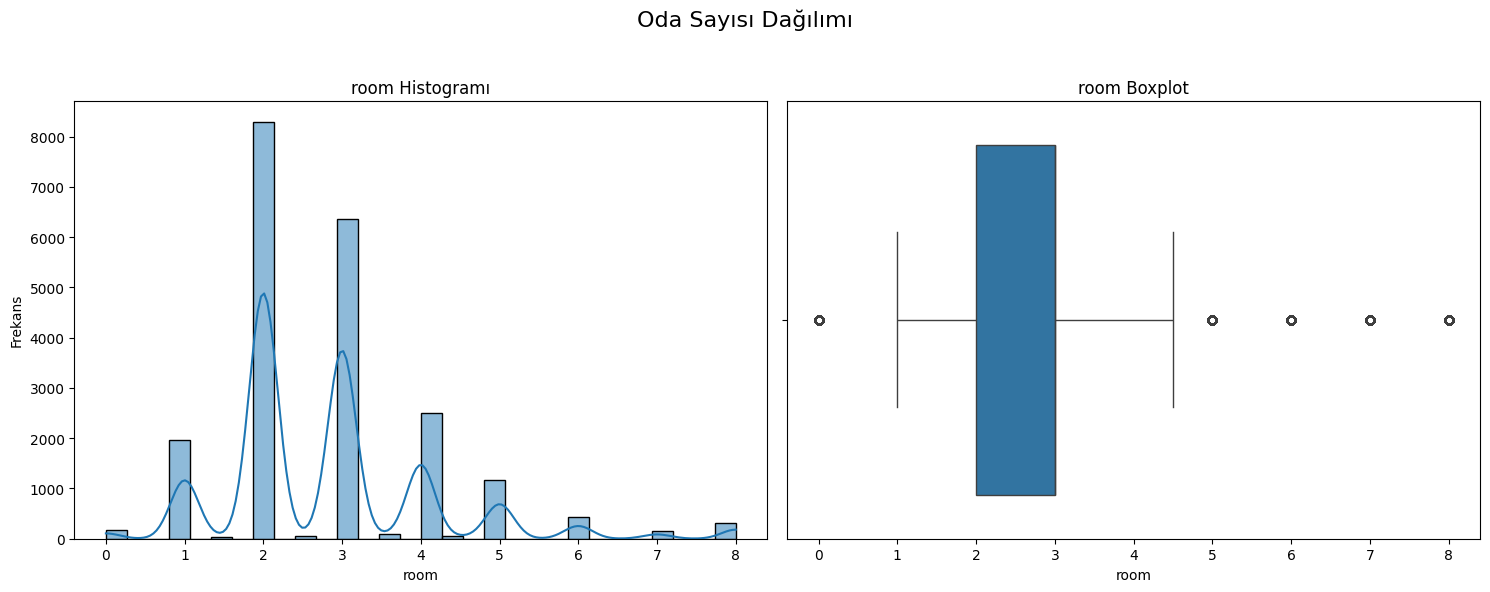

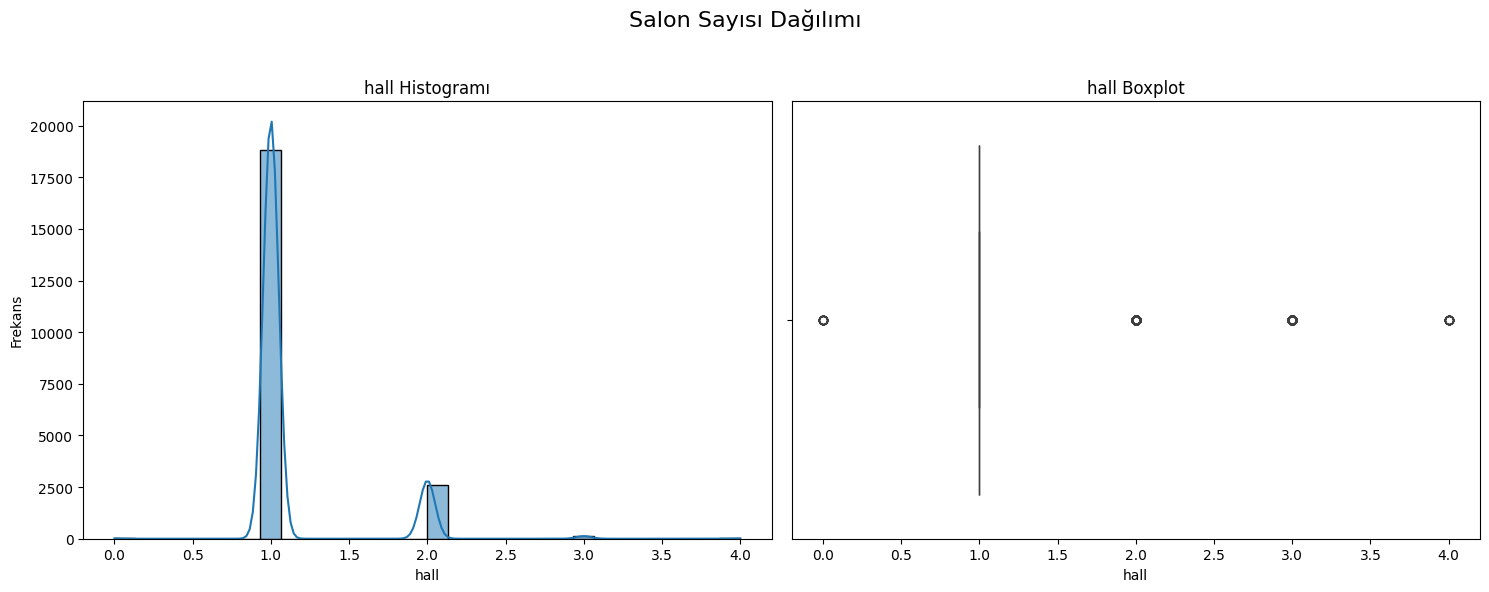

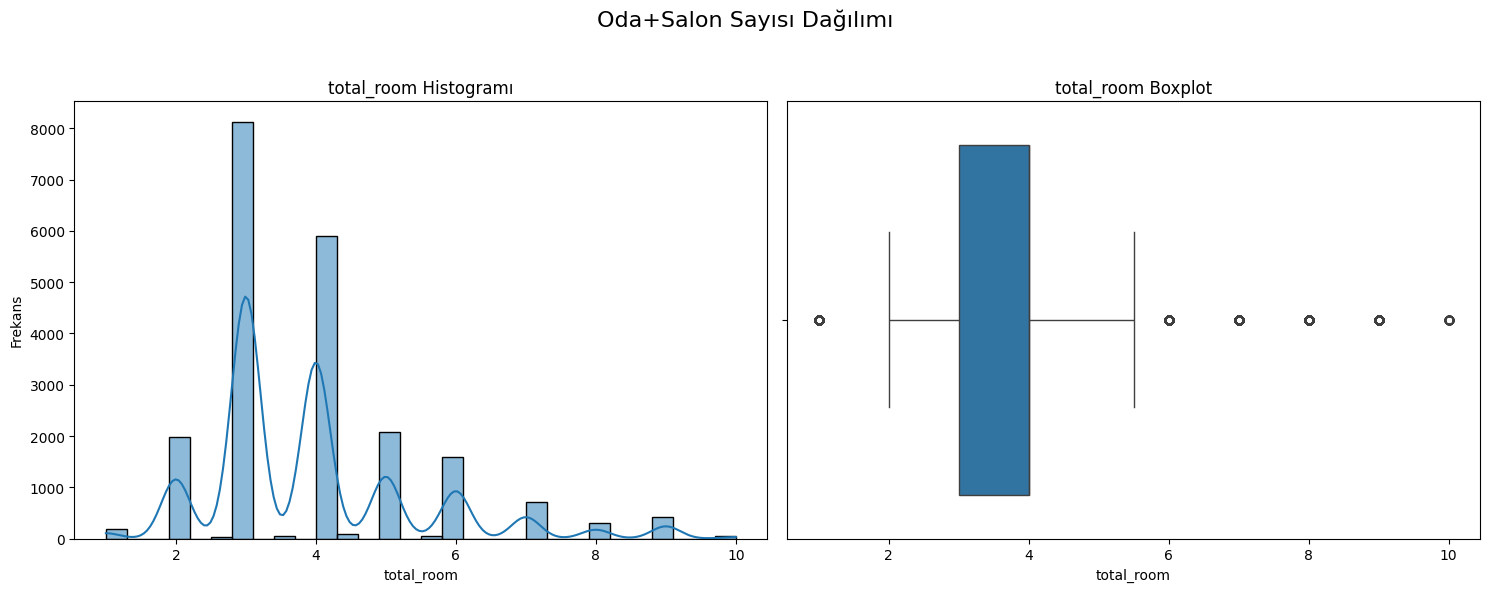

In [184]:
plot_numeric_distribution_side_by_side(df, 'room',title="Oda Sayısı Dağılımı")
plot_numeric_distribution_side_by_side(df, 'hall',title="Salon Sayısı Dağılımı")
plot_numeric_distribution_side_by_side(df, 'total_room',title="Oda+Salon Sayısı Dağılımı")

- Oda sayısı, Salon sayısı ve Toplam Oda sayısı dağılımları şekildeki gibidir. 
- Salon sayısında en çok örnek 1 odadadır.
- Oda sayısında 8 odaya kadar örnek bulunmaktadır. Ortalaması 2-3 aralığındandır.

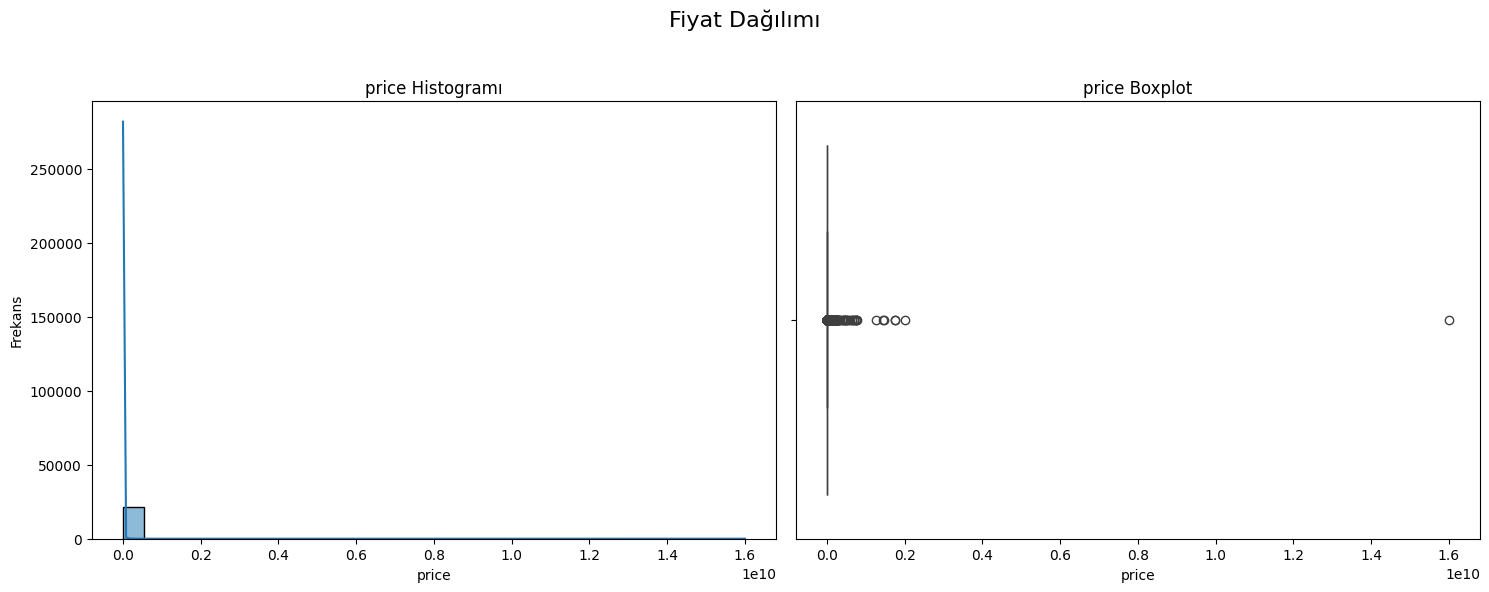

In [185]:
plot_numeric_distribution_side_by_side(df, 'price',title="Fiyat Dağılımı")

- Fiyat dağılımı incelendiğinde, aşırı uç değerlerin bulunduğu ve bu değerlerin potansiyel `aykırı değerler (outliers)` olabileceği belirlenmiştir.

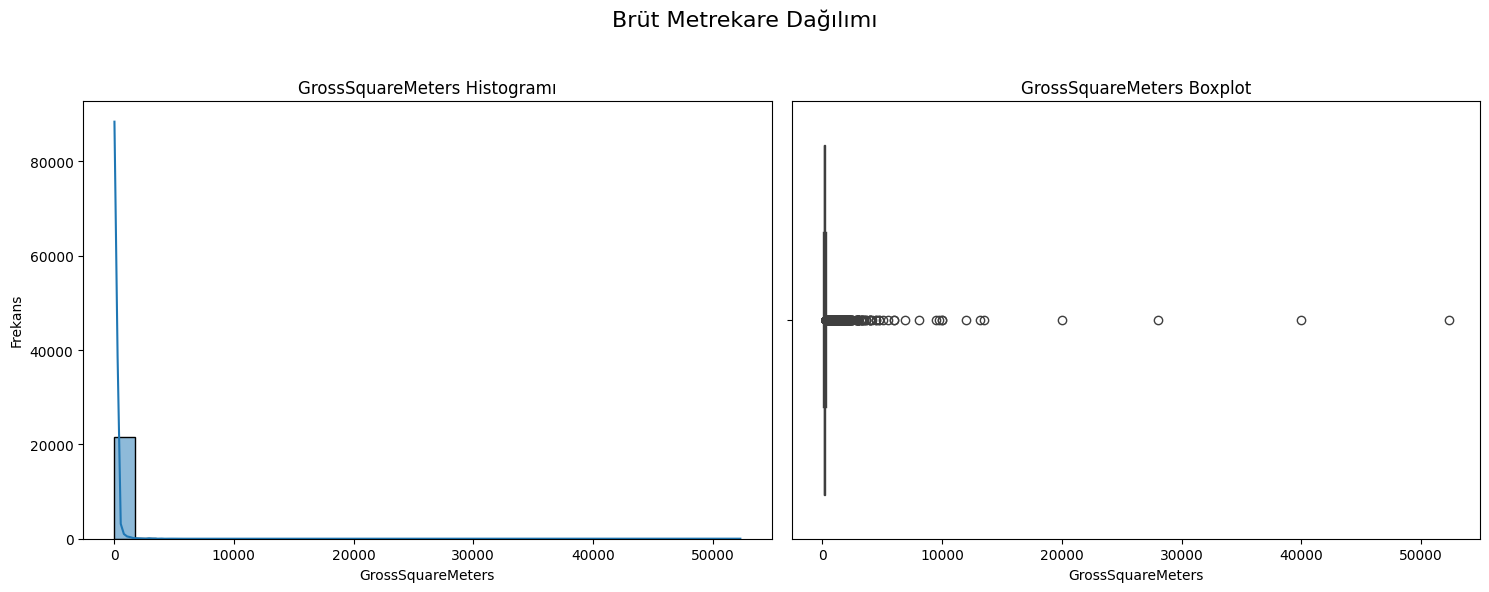

In [186]:
plot_numeric_distribution_side_by_side(df, 'GrossSquareMeters',title="Brüt Metrekare Dağılımı")

- Benzer durum Brüt Metrekare için de geçerli

## 1.5-Aykırı Değerlerin Temizlenmesi

In [187]:
df["price_per_sqmt"] = df["price"] / df["GrossSquareMeters"]
df["price_per_room"] = df["price"] / df["total_room"]
df["sqmt_per_room"] = df["GrossSquareMeters"] / df["total_room"]

Aykırı değerleri temizlerken faydalı olabilecek yeni değerler tanımlanıyor
- Metrekare başına fiyat hesaplanıyor (`price_per_sqmt`)  
- Oda başına fiyat hesaplanıyor (`price_per_room`)  
- Oda başına düşen metrekare miktarı hesaplanıyor (`sqmt_per_room`)

In [188]:
df.shape

(21569, 11)

- Temizlemeden önce `21569` örneğe sahibiz

In [189]:
df.head()

,district,price,GrossSquareMeters,ItemStatus,NumberOfRooms,room,hall,total_room,price_per_sqmt,price_per_room,sqmt_per_room
0,adalar,3100000.0,160,Eşyalı,3+1,3.0,1.0,4.0,19375.000000,7.750000e+05,40.000000
1,adalar,1600000.0,120,Eşyalı,2+1,2.0,1.0,3.0,13333.333333,5.333333e+05,40.000000
2,adalar,18500000.0,350,Boş,3+1,3.0,1.0,4.0,52857.142857,4.625000e+06,87.500000
3,adalar,9500000.0,550,Boş,8+ Oda,8.0,1.0,9.0,17272.727273,1.055556e+06,61.111111
4,adalar,25000000.0,840,Boş,8+ Oda,8.0,1.0,9.0,29761.904762,2.777778e+06,93.333333


In [190]:
df[["price_per_sqmt","price_per_room","sqmt_per_room","price","GrossSquareMeters","total_room"]].describe()

,price_per_sqmt,price_per_room,sqmt_per_room,price,GrossSquareMeters,total_room
count,2.156900e+04,2.156900e+04,21569.000000,2.156900e+04,21569.000000,21569.000000
mean,2.509461e+04,1.107594e+06,45.730090,5.070131e+06,181.289814,3.924359
std,9.293160e+05,2.834657e+07,248.734918,1.141099e+08,589.903092,1.516467
min,7.500188e-03,3.888889e+00,4.500000,2.000000e+01,32.000000,1.000000
25%,7.600000e+00,2.416667e+02,30.000000,7.800000e+02,95.000000,3.000000
50%,9.727273e+03,3.500000e+05,35.000000,1.350000e+06,125.000000,4.000000
75%,1.944444e+04,7.700000e+05,40.666667,2.816500e+06,175.000000,4.000000
max,1.333333e+08,4.000000e+09,26150.000000,1.600000e+10,52300.000000,10.000000


1. `price_per_sqmt (Metrekare Başına Fiyat)`
- Ortalama: ~25.005 TL/m²
- Standart Sapma: Çok yüksek (~920.837), yani veriler oldukça dağılmış.
- Min-Max: 0.0075 – 133.333.333

En yüksek değer ve standart sapmanın aşırı büyük olması, aykırı (outlier) gözlemlerin varlığına işaret ediyor.
*25.* yüzdelik dilim (Q1): ~7.65 TL/m²; bu da bazı çok düşük fiyatlı veri noktalarının olduğunu gösteriyor.

---
2. `price_per_room (Oda Başına Fiyat)`
- Ortalama: ~1.101.316 TL/oda
- Standart Sapma: 28 milyon TL → çok yüksek!
- Min-Max: 3.88 – 4 milyar TL

Yine aşırı uç değerler mevcut.
Ortanca (medyan) değer: 353.333 TL → ortalamadan çok daha düşük → pozitif çarpıklık (right-skewed distribution).

---
3. `sqmt_per_room (Oda Başına m²)`
- Ortalama: 45.53 m²
- Standart Sapma: 246.47 m²
- Min-Max: 4.5 – 26.150 m²

26.150 m² bir oda olamaz → veri hatası veya uç bir değer.
yüzdelik dilim bile sadece 40.5 m², yani bu maksimum değer kesinlikle aykırı.

---
4. `price (Toplam Fiyat)`
- Ortalama: 5.028.601 TL
- Standart Sapma: 113 milyon TL (!), çok yüksek.
- Min-Max: 20 TL – 16 milyar TL

20 TL’ye satılan gayrimenkul olamaz → muhtemelen eksik/hatalı veri.
Ortalama, medyandan çok daha yüksek → yine pozitif çarpıklık söz konusu.

---
5. `GrossSquareMeters (Brüt Metrekare)`
- Ortalama: 180 m²
- Standart Sapma: 584 m²
- Min-Max: 32 – 52.300 m²

52.300 m² aşırı uç bir değer (örneğin alışveriş merkezi olabilir).
25–75. yüzdelik aralık: 95–175 m² → çoğunlukla orta büyüklükte daireler.

---
6. `total_room (Toplam Oda Sayısı)`
- Ortalama: 3.92
- Medyan: 4
- Min-Max: 1 – 10

Makul aralıkta.
Veride çok ekstrem bir durum yok gibi görünüyor.

- Aykırı değerlerin veri setinden ayıklanmasında, istatistiksel bir yöntem olan Interquartile Range (IQR) yöntemi kullanılmıştır.

In [191]:
# price_per_sqmt maskesi
Q1 = df["price_per_sqmt"].quantile(0.25)
Q3 = df["price_per_sqmt"].quantile(0.75)
IQR = Q3 - Q1
mask_sqmt = (df["price_per_sqmt"] >= Q1 - 1.5*IQR) & (df["price_per_sqmt"] <= Q3 + 1.5*IQR)

# price_per_room maskesi
Q1 = df["price_per_room"].quantile(0.25)
Q3 = df["price_per_room"].quantile(0.75)
IQR = Q3 - Q1
mask_room = (df["price_per_room"] >= Q1 - 1.5*IQR) & (df["price_per_room"] <= Q3 + 1.5*IQR)

# sqmt_per_room maskesi
Q1 = df["sqmt_per_room"].quantile(0.25)
Q3 = df["sqmt_per_room"].quantile(0.75)
IQR = Q3 - Q1
mask_sqmt_room = (df["sqmt_per_room"] >= Q1 - 1.5*IQR) & (df["sqmt_per_room"] <= Q3 + 1.5*IQR)

# Tümünü birleştirerek tek filtreleme yap
df = df[mask_sqmt & mask_room & mask_sqmt_room]


- Üç farklı sütun (`price_per_sqmt`, `price_per_room`, `sqmt_per_room`) için IQR yöntemine göre aykırı değerler belirleniyor  
- Her sütun için çeyrekler arası aralık (IQR) hesaplanarak alt ve üst sınırlar oluşturuluyor  
- Her sütun için birer mantıksal maske (koşul filtresi) tanımlanıyor  
- Son olarak bu maskeler birleştirilerek yalnızca tüm koşulları sağlayan (aykırı olmayan) satırlar veri setinde tutuluyor

In [192]:
df[["price_per_sqmt","price_per_room","sqmt_per_room"]].describe()

,price_per_sqmt,price_per_room,sqmt_per_room
count,18938.000000,1.893800e+04,18938.000000
mean,10047.540884,3.683602e+05,34.795653
std,11161.636524,4.294629e+05,6.415854
min,0.104545,4.600000e+00,14.444444
25%,7.100000,2.266667e+02,30.000000
50%,8421.052632,2.875000e+05,33.333333
75%,16304.347826,5.750000e+05,38.333333
max,48484.848485,1.920000e+06,56.250000


1. `price_per_sqmt` : Aykırı değerler çıkarıldıktan sonra dağılım çok daha mantıklı ve sıkı hale gelmiş. Standart sapmanın aşırı düşmesi, artık verilerin birbirine daha yakın olduğu anlamına geliyor. Ortalama ve medyan arasındaki fark azaldı
2. `price_per_room` : Bu sütundaki dağılım artık normal sınırlar içinde. Eskiden milyar seviyelerinde olan uç fiyatlar artık yok. Ortalama, medyana yaklaştı
3. `sqmt_per_room` : Oda başına 26.000 m² gibi gerçek dışı değerler atıldığı için şimdi dağılım daha homojen ve güvenilir. Ortalama 34.79 m² ile oturmuş düzeyde.

In [193]:
df.shape

(18938, 11)

- 21569 olan ilk veriden elimizde 18938 veri kaldı.

## 1.6-İleri Aykırı Değer Temizliği

- Belirli bir ilçedeki evlerin fiyat/bürt metrekare ilişkisi toplam oda sayısına göre gruplanarak incelenecektir.
- Oda sayısı arttıkça metrekare başına fiyat genellikle azalır. Varsayımından yola çıkılacaktır.
- İlham alınan proje: https://www.kaggle.com/code/yaarvnpatr/house-price-estimation-in-stanbul#3.Data-cleaning

In [194]:
def plot_scatter_chart_optimized(df, district):
    df_district = df[df["district"].str.lower() == district.lower()]
    rooms = sorted(df_district["total_room"].unique())
    colors = plt.get_cmap('tab10', len(rooms))
    
    # 1. Grafik: Price vs GrossSquareMeters scatter
    plt.figure(figsize=(15,10))
    for i, room in enumerate(rooms):
        subset = df_district[df_district["total_room"] == room]
        plt.scatter(subset["GrossSquareMeters"], subset["price"],
                    color=colors(i), label=f"{room} room{'s' if room > 1 else ''}", s=50, alpha=0.7)
    plt.xlabel("Total Square Meter Area")
    plt.ylabel("Price")
    plt.title(f"{district.capitalize()} - Gross Square Meters vs Price")
    plt.legend(title="Number of Rooms")
    plt.grid(True)
    plt.show()
    
    # 2. Grafik: Oda sayısına göre ortalama metrekare ve fiyat
    avg_stats = df_district.groupby("total_room")[["GrossSquareMeters", "price"]].mean()
    
    fig, ax1 = plt.subplots(figsize=(12,6))
    
    ax1.set_xlabel("Number of Rooms")
    ax1.set_ylabel("Average Gross Square Meters", color='tab:blue')
    ax1.plot(avg_stats.index, avg_stats["GrossSquareMeters"], marker='o', linestyle='-', color='tab:blue', label='Avg Sq Meters')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel("Average Price", color='tab:red')
    ax2.plot(avg_stats.index, avg_stats["price"], marker='s', linestyle='--', color='tab:red', label='Avg Price')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # Legends için:
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    
    plt.title(f"{district.capitalize()} - Average Square Meters and Price by Number of Rooms")
    plt.show()

- Belirtilen ilçedeki (`district`) veriyi filtreler  
- İlçedeki farklı toplam oda sayılarını alır ve renk paleti oluşturur  
- Her oda sayısı için metrekareye karşı fiyatı scatter plot ile çizer  
- Grafik üzerinde oda sayısına göre renk ve açıklama eklenir  
- Ekseni, başlık ve ızgara ayarları yapılır, grafik gösterilir

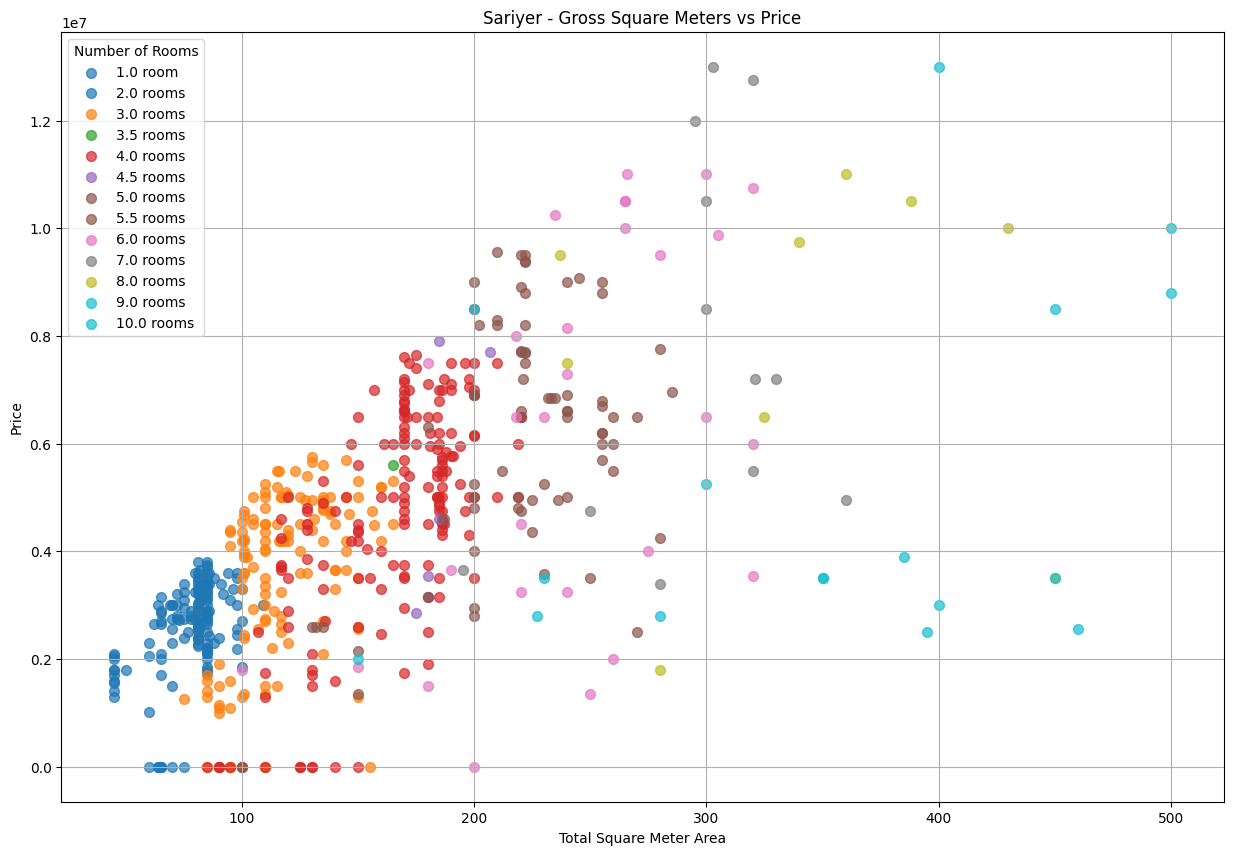

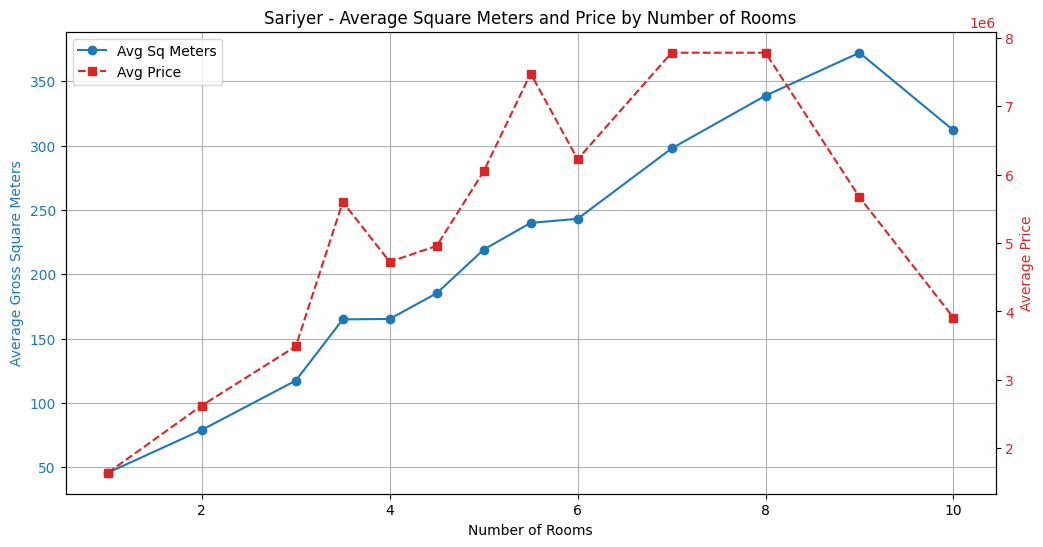

In [195]:
plot_scatter_chart_optimized(df, "sariyer")

- Grafikten de görülebildiği üzere bir ilçedeki evlerin brüt metrekaresi arttıkça fiyatı artar yaklaşımı doğru.
- Ortalama brüt metrekare arttığında oda sayısında bir artış gözlemlenir. Aynı zamanda oda sayısı artışı beraberinde fiyat artışını da getirir.

- Bu yaklaşımdan yola çıkarak veri temizliği yapılacaktır; yani metrekare, oda sayısı ve fiyat arasındaki tutarlılık göz önünde bulundurularak aykırı veya tutarsız veriler tespit edilip çıkarılacaktır.

- Özellikle, aynı ilçedeki farklı oda sayılarına sahip evlerin metrekare başına fiyatları karşılaştırılır.

- Eğer daha fazla odalı evlerin fiyatları, bir önceki oda sayısındaki evlerin ortalamasından belirli bir eşik (threshold) kadar daha düşük ise, bu veriler mantıksal olarak tutarsız kabul edilip çıkarılır. (Çünkü oda sayısı ile fiyat doğru orantılı olmalı)

- Benzer şekilde, daha az odalı evlerin fiyatları, bir sonraki (daha fazla odalı) oda sayısındaki evlerin ortalamasından belirli bir eşik kadar daha yüksek ise, bu da aykırı veri olarak kabul edilir ve temizlenir. (Benzer sebeple)

---

*`Neden iki yönlü?`*

Örnek 1 – Alt Uç (Beklenenden ucuz büyük evler):
Kadıköy ilçesinde, 2 odalı evlerin metrekare başına ortalama fiyatı 12.000 TL iken, bazı 3 odalı evlerde bu değer 8.000 TL seviyelerinde olabilir. Bu, daha fazla odalı bir evin, daha az odalıdan ucuz olması anlamına gelir ki piyasa normlarına aykırıdır. Bu tip durumlar alt uçtaki tutarsızlıklardır ve temizlenmelidir.

Örnek 2 – Üst Uç (Beklenenden pahalı küçük evler):
Beşiktaş ilçesinde 3 odalı evlerin ortalama fiyatı 14.000 TL/m² iken, bazı 2 odalı evler 20.000 TL/m² gibi aşırı yüksek fiyatlarda olabilir. Bu da oda sayısıyla orantısız şekilde pahalı olan küçük evleri temsil eder. Bu tür uç değerler de analizleri yanıltabileceği için çıkarılmalıdır.

---

In [196]:
def remove_room_outliers_statistical(df, threshold=0.5):
    exclude_indices = []
    
    for district, district_df in df.groupby("district"):
        room_stats = district_df.groupby("total_room")["price_per_sqmt"].agg(["mean", "std", "count"])
        
        for room, room_df in district_df.groupby("total_room"):
            prev_room = room - 1
            next_room = room + 1
            
            # Daha fazla odalı evlerin fiyatı, bir az odalıların ortalamasından 'threshold' std sapmasından düşükse çıkar
            if prev_room in room_stats.index and room_stats.loc[prev_room, "count"] > 5:
                prev_mean = room_stats.loc[prev_room, "mean"]
                prev_std = room_stats.loc[prev_room, "std"]
                cutoff_low = prev_mean - threshold * prev_std
                low_price_indices = room_df[room_df["price_per_sqmt"] < cutoff_low].index
                exclude_indices.extend(low_price_indices)
            
            # Daha az odalı evlerin fiyatı, bir fazla odalıların ortalamasından 'threshold' std sapmasından yüksekse çıkar
            if next_room in room_stats.index and room_stats.loc[next_room, "count"] > 5:
                next_mean = room_stats.loc[next_room, "mean"]
                next_std = room_stats.loc[next_room, "std"]
                cutoff_high = next_mean + threshold * next_std
                high_price_indices = room_df[room_df["price_per_sqmt"] > cutoff_high].index
                exclude_indices.extend(high_price_indices)
    
    return df.drop(index=exclude_indices)


df = remove_room_outliers_statistical(df)

In [197]:
df.shape

(9440, 11)

- 21569 olan ilk veriden elimizde 9440 veri kaldı.

In [198]:
df["price"]=df["price"].astype('Float64')
df["GrossSquareMeters"]=df["GrossSquareMeters"].astype('Float64')

- tip dönüşümleri yapılır

# 2-Regresyon Modeli (Fiyat Tahmini)

In [199]:
reg_df=df[["price","GrossSquareMeters","ItemStatus","room","hall","district"]]
reg_df.head()

,price,GrossSquareMeters,ItemStatus,room,hall,district
0,3100000.0,160.0,Eşyalı,3.0,1.0,adalar
1,1600000.0,120.0,Eşyalı,2.0,1.0,adalar
5,7000000.0,200.0,Boş,3.0,2.0,adalar
6,3250000.0,400.0,Boş,8.0,1.0,adalar
7,2850000.0,250.0,Boş,5.0,1.0,adalar


- Analiz için kullanılan değerler çıkarılır ve `reg_df` olarak yeni bir dataframe'de tutulur.

## 2.1-Özellik Mühendisliği

In [200]:
reg_df = pd.get_dummies(reg_df, columns=["district","ItemStatus"], drop_first=True)
reg_df

,price,GrossSquareMeters,room,hall,district_arnavutkoy,district_atasehir,district_avcilar,district_bagcilar,district_bahcelievler,district_bakirkoy,...,district_sile,district_silivri,district_sisli,district_sultanbeyli,district_sultangazi,district_tuzla,district_umraniye,district_uskudar,district_zeytinburnu,ItemStatus_Eşyalı
0,3100000.0,160.0,3.0,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,1600000.0,120.0,2.0,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5,7000000.0,200.0,3.0,2.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,3250000.0,400.0,8.0,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,2850000.0,250.0,5.0,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25133,1300000.0,74.0,1.0,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
25135,1650000.0,85.0,2.0,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
25137,2650000.0,120.0,2.0,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
25141,450.0,75.0,1.0,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


- `district` ve `ItemStatus` kategorik sütunları one-hot encoding yöntemiyle sayısal hale dönüştürülüyor  
- `pd.get_dummies()` fonksiyonu kullanılarak her kategori için ayrı sütun oluşturuluyor  
- `drop_first=True` parametresi, çoklu doğrusal bağlantıyı (multicollinearity) önlemek için ilk kategoriyi düşer  
- Sonuç olarak modellemeye uygun sayısal bir veri çerçevesi (`reg_df`) elde ediliyor


In [201]:
reg_df.shape

(9440, 43)

## 2.2-Veri Setinin Oluşturulması

In [202]:
X = reg_df.drop(columns=['price'])
y = reg_df['price']

- `X`: Bağımsız değişkenleri (özellikleri) içeren veri çerçevesi olarak oluşturulur  
- `y`: Hedef değişken olan `price` sütunu seçilerek bağımlı değişken olarak tanımlanır  
- Bu ayrım, regresyon modeli eğitimi için gereklidir

In [203]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

- `StandardScaler` ile tüm özellikler (bağımsız değişkenler) standart ölçeğe getirilir  
- Bu işlem, ortalamayı 0, standart sapmayı 1 yaparak ölçek farklarını ortadan kaldırır  
- Dönüştürülen veriler `X_scaled_df` adlı yeni bir `DataFrame` olarak saklanır  
- Model eğitimi ve özellikle mesafeye duyarlı algoritmalar (KNN, SVM, vb.) için önemlidir

## 2.3-Train/Test Split

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

- Veri seti eğitim ve test olmak üzere ikiye ayrılır  
- `test_size=0.2`: Verinin %20’si test, %80’i eğitim için kullanılır

## 2.4-Model Selection

In [218]:
regressors = [
    ('Ridge', Ridge()),
    ('LinearRegression', LinearRegression()),
    ('KNN', KNeighborsRegressor()),
    ('DecisionTree', DecisionTreeRegressor()),
    ('XGBoost', XGBRegressor()),
    ('GradientBoosting', GradientBoostingRegressor()),
    ('RandomForest', RandomForestRegressor())
]

reg_results = []

for name, model in regressors:
    pipe = Pipeline([('reg', model)])
    
    # Cross-validation R2 skoru
    score = cross_val_score(pipe, X_train, y_train, cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=42), scoring='r2')
    mean_r2 = np.mean(score)
    
    # Fit+predict süresi
    start = time.time()
    pipe.fit(X_train, y_train)
    pipe.predict(X_train)
    end = time.time()
    elapsed_time = end - start
    
    # Süre/Doğruluk oranı
    accuracy_time_ratio = mean_r2/elapsed_time if elapsed_time != 0 else np.inf
    
    reg_results.append({
        'Model': name,
        'Mean_R2': mean_r2,
        'Time_sec': elapsed_time,
        'R2_time_ratio': accuracy_time_ratio
    })

# DataFrame oluştur
df_reg_results = pd.DataFrame(reg_results)

# En kısa sürede en yüksek performans verene göre sırala
df_reg_results = df_reg_results.sort_values(by=["Mean_R2",'R2_time_ratio'], ascending=[False,False]).reset_index(drop=True)

df_reg_results.head()

,Model,Mean_R2,Time_sec,R2_time_ratio
0,RandomForest,0.801853,3.858932,0.207791
1,KNN,0.793809,0.251861,3.151775
2,XGBoost,0.790488,0.159027,4.970773
3,Ridge,0.776723,0.008200,94.720383
4,LinearRegression,0.776722,0.155628,4.990891


- Yedi farklı regresyon algoritması bir liste (`regressors`) içinde tanımlanır:
  - `Ridge`
  - `LinearRegression`
  - `KNeighborsRegressor`
  - `DecisionTreeRegressor`
  - `XGBRegressor`
  - `GradientBoostingRegressor`
  - `RandomForestRegressor`

- Her model için:
  - `Pipeline` oluşturulur (burada yalnızca model içeriyor)
  - `ShuffleSplit` ile 5 kez rastgele eğitim-test ayrımı yapılır (test verisi oranı %20)
  - `cross_val_score` ile her modelin 5 katlı `R²` (determinasyon katsayısı) puanı hesaplanır
  - Ortalama `R²` skoru konsola yazdırılır

- RandomForest az bir farkla daha iyi sonuç vermesine rağmen hem yakın hem de daha hızlı sonuçlar verdiği için XGBoost ile devam edilmiştir.

## 2.5-Hiperparametre Optimizasyonu

In [219]:
pipe = Pipeline([
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid = {
    'xgb__n_estimators': [100, 300, 500, 700, 900],
    'xgb__max_depth': [3, 5, 7, 9],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.15],
    'xgb__subsample': [0.7, 1],
    'xgb__colsample_bytree': [0.7, 1],
    'xgb__gamma': [0, 1, 5]
}

search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=15, cv=3, scoring='r2', verbose=1, n_jobs=-1)
search.fit(X_train, y_train)
print("\nBest XGBoost params:", search.best_params_)

# Test skorunu yazdır
final_model = search.best_estimator_
y_pred = final_model.predict(X_test)
print("\nFinal XGBoost R2 Score:", r2_score(y_test, y_pred))

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best XGBoost params: {'xgb__subsample': 1, 'xgb__n_estimators': 100, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 1, 'xgb__colsample_bytree': 0.7}

Final XGBoost R2 Score: 0.8091012239456177


- `Pipeline` içine `XGBRegressor` modeli yerleştirilir  
- `param_grid` ile XGBoost için hiperparametre aralıkları tanımlanır (ağaç sayısı, derinlik, öğrenme hızı vb.)  
- `RandomizedSearchCV` ile 15 farklı rastgele parametre kombinasyonu denenir, 3 katlı çapraz doğrulama yapılır  
- En iyi parametreler `search.best_params_` ile bulunur ve yazdırılır  
- Bu en iyi model `final_model` olarak seçilir  
- Test verisi üzerinde tahmin yapılır ve `R²` skoru hesaplanarak model performansı değerlendirilir  

In [221]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nFinal XGBoost MAE Score:", mae)
print("\nFinal XGBoost MSE Score:", mse)
print("\nFinal XGBoost R2 Score:", r2)


Final XGBoost MAE Score: 374359.875

Final XGBoost MSE Score: 545755561984.0

Final XGBoost R2 Score: 0.8091012239456177


In [222]:
with open("models/home_price_model.pkl", "wb") as f:
    pickle.dump({
        "model": final_model,
        "scaler": scaler,
        "columns": X.columns.tolist()
    }, f)

- Eğitilen `final_model`, kullanılan `scaler` ve modelde kullanılan özellik sütunları (`X.columns`) bir sözlük içinde saklanıyor  
- Bu sözlük, `pickle` ile `"models/home_price_model.pkl"` dosyasına ikili (binary) formatta yazılıyor  
- Böylece model, ön işleme bilgileri ve sütun yapısı birlikte kaydedilip ileride kolayca yüklenip kullanılabilir hale geliyor

# 3-Anomali Tespit Modeli

In [ ]:
anomaly_df=reg_df.copy()
anomaly_df.head()

,price,GrossSquareMeters,room,hall,district_arnavutkoy,district_atasehir,district_avcilar,district_bagcilar,district_bahcelievler,district_bakirkoy,...,district_sile,district_silivri,district_sisli,district_sultanbeyli,district_sultangazi,district_tuzla,district_umraniye,district_uskudar,district_zeytinburnu,ItemStatus_Eşyalı
0,3100000.0,160.0,3.0,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,1600000.0,120.0,2.0,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5,7000000.0,200.0,3.0,2.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,3250000.0,400.0,8.0,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,2850000.0,250.0,5.0,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


- Anomali Tespitinde Fiyat Tahmininde hazırladığımız veri setinden yararlanacağız

## 3.1-Modelin Seçilmesi

In [232]:
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42
)

- `IsolationForest` anomali tespiti için oluşturulur  
- `n_estimators=100`: 100 adet izolasyon ağacı kullanılır  
- `contamination=0.01`: Verinin %1’i anomali (aykırı değer) olarak kabul edilir

Veri etiketli olmadığı için denetimsiz öğrenme gerçekleşir

In [233]:
iso_forest.fit(anomaly_df)

IsolationForest(contamination=0.01, random_state=42)

In [234]:
preds = iso_forest.predict(anomaly_df)
anomaly_result=df.copy()
# Sonuçları DataFrame'e ekle
anomaly_result['anomaly'] = preds
anomaly_result.head()

,district,price,GrossSquareMeters,ItemStatus,NumberOfRooms,room,hall,total_room,price_per_sqmt,price_per_room,sqmt_per_room,anomaly
0,adalar,3100000.0,160.0,Eşyalı,3+1,3.0,1.0,4.0,19375.000000,7.750000e+05,40.000000,1
1,adalar,1600000.0,120.0,Eşyalı,2+1,2.0,1.0,3.0,13333.333333,5.333333e+05,40.000000,1
5,adalar,7000000.0,200.0,Boş,3+2,3.0,2.0,5.0,35000.000000,1.400000e+06,40.000000,1
6,adalar,3250000.0,400.0,Boş,8+ Oda,8.0,1.0,9.0,8125.000000,3.611111e+05,44.444444,1
7,adalar,2850000.0,250.0,Boş,5+1,5.0,1.0,6.0,11400.000000,4.750000e+05,41.666667,1


- İzolasyon Ormanı modeliyle gözlemler anomali mi (−1) yoksa normal mi (+1) olarak etiketlenir  

## 3.2-Anomalilerin Gözlemi

In [235]:
anomalies = anomaly_result[anomaly_result['anomaly'] == -1]
anomalies.head()

,district,price,GrossSquareMeters,ItemStatus,NumberOfRooms,room,hall,total_room,price_per_sqmt,price_per_room,sqmt_per_room,anomaly
274,arnavutkoy,7000000.0,330.0,Eşyalı,6+2,6.0,2.0,8.0,21212.121212,875000.0,41.25,-1
394,atasehir,3699000.0,550.0,Boş,6+4,6.0,4.0,10.0,6725.454545,369900.0,55.00,-1
501,atasehir,1750000.0,400.0,Eşyalı,7+1,7.0,1.0,8.0,4375.000000,218750.0,50.00,-1
583,atasehir,3620000.0,550.0,Boş,6+4,6.0,4.0,10.0,6581.818182,362000.0,55.00,-1
640,atasehir,6800000.0,306.0,Boş,7+3,7.0,3.0,10.0,22222.222222,680000.0,30.60,-1


- Anomaliler şekildeki gibidir

In [236]:
print(f"Toplam anomali sayısı: {len(anomalies)}")

Toplam anomali sayısı: 95


In [237]:
with open("models/anomaly_model.pkl", "wb") as f:
    pickle.dump({
        "model": iso_forest,
        "columns": anomaly_df.columns.tolist()
    }, f)

Bu işlem, modeli daha sonra tekrar kullanmak üzere diske kaydeder.

In [238]:
anomaly_result.to_csv('dataset/processed/anomaly_result.csv', index=False)

# 4-Kümeleme Modeli (Ev Tipini Belirleme)

In [240]:
cluster_df = df.copy()
cluster_df.head()

,district,price,GrossSquareMeters,ItemStatus,NumberOfRooms,room,hall,total_room,price_per_sqmt,price_per_room,sqmt_per_room
0,adalar,3100000.0,160.0,Eşyalı,3+1,3.0,1.0,4.0,19375.000000,7.750000e+05,40.000000
1,adalar,1600000.0,120.0,Eşyalı,2+1,2.0,1.0,3.0,13333.333333,5.333333e+05,40.000000
5,adalar,7000000.0,200.0,Boş,3+2,3.0,2.0,5.0,35000.000000,1.400000e+06,40.000000
6,adalar,3250000.0,400.0,Boş,8+ Oda,8.0,1.0,9.0,8125.000000,3.611111e+05,44.444444
7,adalar,2850000.0,250.0,Boş,5+1,5.0,1.0,6.0,11400.000000,4.750000e+05,41.666667


- Clustering algoritması kategorik değerlerle de çalışabildiği için ana df kopyalanmıştır

In [ ]:
cluster_df=cluster_df.drop(["NumberOfRooms","price_per_sqmt","price_per_room","sqmt_per_room","total_room"],axis=1)
le = LabelEncoder()

encoders = {}

for col in cluster_df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    cluster_df[col] = le.fit_transform(cluster_df[col])
    encoders[col] = le
cluster_df.head()

,district,price,GrossSquareMeters,ItemStatus,room,hall
0,0,3100000.0,160.0,1,3.0,1.0
1,0,1600000.0,120.0,1,2.0,1.0
5,0,7000000.0,200.0,0,3.0,2.0
6,0,3250000.0,400.0,0,8.0,1.0
7,0,2850000.0,250.0,0,5.0,1.0


- `drop([...])`: Kümeleme için gereksiz sütunlar çıkarılır.  
- `LabelEncoder`: Kategorik (object) sütunlar sayısala çevrilir.  
- `encoders`: Her sütun için encoder saklanır, geri dönüşüm (decode) için kullanılır.

## 4.1-Model Selection

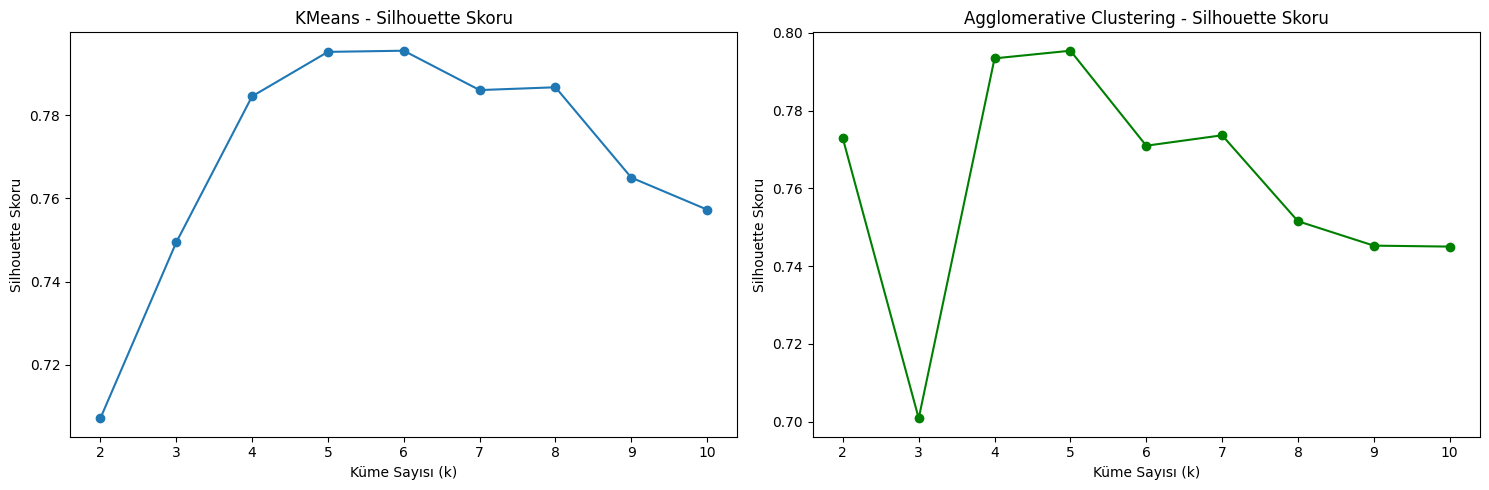

In [ ]:
kmeans_silhouette_scores = []
kmeans_sse = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(cluster_df)
    score = silhouette_score(cluster_df, labels)
    kmeans_silhouette_scores.append(score)
    kmeans_sse.append(kmeans.inertia_)

# Agglomerative Clustering için
agg_silhouette_scores = []
for k in k_range:
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(cluster_df)
    score = silhouette_score(cluster_df, labels)
    agg_silhouette_scores.append(score)

# 🔧 Sonuçları görselleştirme
plt.figure(figsize=(15, 5))

# KMeans Silhouette
plt.subplot(1, 2, 1)
plt.plot(k_range, kmeans_silhouette_scores, marker='o')
plt.title("KMeans - Silhouette Skoru")
plt.xlabel("Küme Sayısı (k)")
plt.ylabel("Silhouette Skoru")

# Agglomerative Clustering
plt.subplot(1, 2, 2)
plt.plot(k_range, agg_silhouette_scores, marker='o', color='green')
plt.title("Agglomerative Clustering - Silhouette Skoru")
plt.xlabel("Küme Sayısı (k)")
plt.ylabel("Silhouette Skoru")

plt.tight_layout()
plt.show()

- Silhoutte Skorlarına bakarak KMeans'in daha iyi sonuç verdiğini gözlemliyoruz

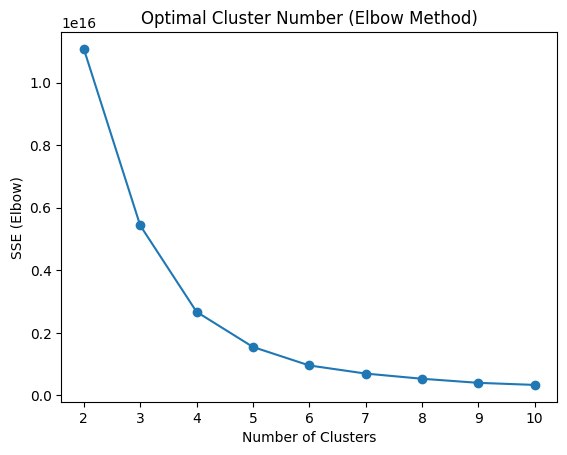

In [246]:
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_df)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Elbow)')
plt.title('Optimal Cluster Number (Elbow Method)')
plt.show()

- Silhouette Skorlarına ve Elbow methoduna bakarak cluster sayısını 5 seçiyoruz

In [247]:
optimal_k = 5 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(cluster_df)

In [248]:
cluster_result=cluster_df.copy()
cluster_result['cluster'] = clusters

In [249]:
cluster_result.groupby('cluster').mean()

,district,price,GrossSquareMeters,ItemStatus,room,hall
cluster,,,,,,
0,18.344493,645.211901,98.078603,0.056526,1.947841,1.004609
1,19.490141,3252356.458216,179.870423,0.045070,3.565258,1.266667
2,19.042111,1471259.073824,144.027294,0.038991,3.001040,1.208474
3,16.281250,11390218.75,360.296875,0.078125,6.226562,1.718750
4,20.628655,5987090.643275,248.666667,0.046784,4.447368,1.324561


- Clusterlara göre labellar belirlenir.

In [250]:
cluster_labels = {
    0: "Az Odalı, Büyük Metrekareli Eski Daireler",
    1: "Lüks Villalar veya Büyük Konut Projeleri",
    2: "Orta Gelir Grubuna Uygun Ekonomik Geniş Konutlar",
    3: "Ultra Lüks, Çok Odalı Geniş Aile Konutları",
    4: "Yeni ve Geniş Lüks Daireler"
}

In [251]:
cluster_result['cluster_label'] = cluster_result['cluster'].map(cluster_labels)

- Clusterlar map edilir

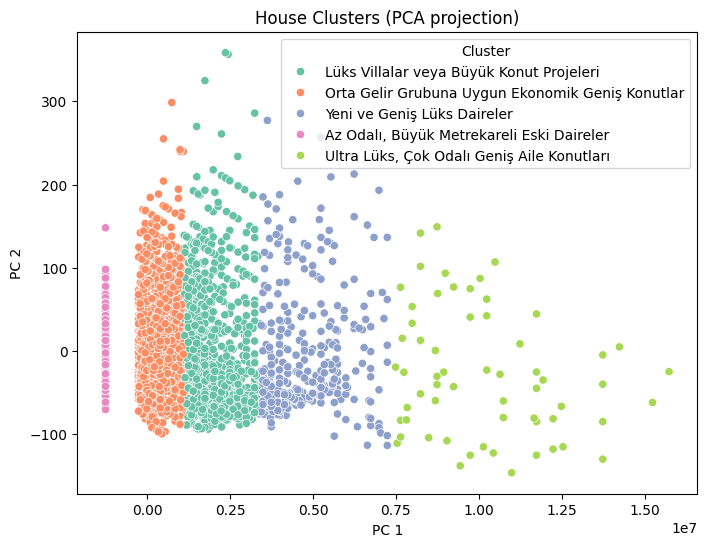

In [252]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(cluster_df)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_result["cluster_label"], palette='Set2')
plt.title('House Clusters (PCA projection)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Cluster')
plt.show()

- `PCA(n_components=2)`: Veriyi 2 bileşene indirger.  
- `fit_transform`: Kümeleme verisini dönüştürür.  
- `sns.scatterplot`: İki ana bileşen üzerinden kümeleri görselleştirir.  
- Grafik başlığı ve eksenler açıklanır, kümeler renklerle gösterilir.

In [253]:
with open("models/cluster_model.pkl", "wb") as f:
    pickle.dump({
        "model": kmeans,
        "encoder":encoders,
        "cluster_labels":cluster_labels,
        "columns": cluster_df.columns.tolist()
    }, f)

- Model daha sonra kullanılmak üzere kaydedilir

In [254]:
cluster_df.to_csv('dataset/processed/cluster_result.csv', index=False)

# 5-Sınıflandırma Modeli (Yatırıma Ugyunluk Tahmini)

In [311]:
classification_df=df.copy()

- Ana df kopyalanır.

In [312]:
classification_df["EligibilityForInvestment"] = data.loc[classification_df.index, "EligibilityForInvestment"]
classification_df.head()

,district,price,GrossSquareMeters,ItemStatus,NumberOfRooms,room,hall,total_room,price_per_sqmt,price_per_room,sqmt_per_room,EligibilityForInvestment
0,adalar,3100000.0,160.0,Eşyalı,3+1,3.0,1.0,4.0,19375.000000,7.750000e+05,40.000000,Bilinmiyor
1,adalar,1600000.0,120.0,Eşyalı,2+1,2.0,1.0,3.0,13333.333333,5.333333e+05,40.000000,Yatırıma Uygun
5,adalar,7000000.0,200.0,Boş,3+2,3.0,2.0,5.0,35000.000000,1.400000e+06,40.000000,Bilinmiyor
6,adalar,3250000.0,400.0,Boş,8+ Oda,8.0,1.0,9.0,8125.000000,3.611111e+05,44.444444,NaN
7,adalar,2850000.0,250.0,Boş,5+1,5.0,1.0,6.0,11400.000000,4.750000e+05,41.666667,Bilinmiyor


- Yatırıma uygunluk verisi ham veriden alınarak eklenir.

In [313]:
classification_df["EligibilityForInvestment"].value_counts()

EligibilityForInvestment
Bilinmiyor              4474
Yatırıma Uygun          3570
Yatırıma Uygun Değil      14
Name: count, dtype: int64

- Veride Yatırıma Uygunluk bilgisi üç kategoriye ayrılmış.  
- En büyük grup **“Bilinmiyor”** (4398 kayıt) olup, bu alandaki eksik ya da belirsiz verileri gösteriyor.  
- “Yatırıma Uygun” olanlar (3532 kayıt) ikinci büyük grubu oluşturuyor, yatırım için uygun olanlar önemli sayıda.  
- “Yatırıma Uygun Değil” ise çok az (sadece 12 kayıt), bu nedenle analizde çok etkili olmayabilir. 


In [314]:
classification_df.isnull().sum()

district                       0
price                          0
GrossSquareMeters              0
ItemStatus                     0
NumberOfRooms                  0
room                           0
hall                           0
total_room                     0
price_per_sqmt                 0
price_per_room                 0
sqmt_per_room                  0
EligibilityForInvestment    1382
dtype: int64

In [315]:
classification_df=classification_df.dropna()

In [316]:
classification_df["EligibilityForInvestment"] = classification_df["EligibilityForInvestment"].replace("Yatırıma Uygun Değil","Riskli")
classification_df["EligibilityForInvestment"] = classification_df["EligibilityForInvestment"].replace("Bilinmiyor","Riskli")
classification_df=classification_df.dropna()

- Sınıfları Yatırıma Uygun ve Riskli olarak iki sınıfa dönüştürdük.

In [317]:
classification_df["EligibilityForInvestment"].value_counts()

EligibilityForInvestment
Riskli            4488
Yatırıma Uygun    3570
Name: count, dtype: int64

- Daha dengeli bir dağılım elde ettik
- Yatırımda riski minimum tutmak için emin olunmayan değerleri Riskli olarak kabul ettik

In [320]:
classification_df["EligibilityForInvestment"].unique()

array(['Riskli', 'Yatırıma Uygun'], dtype=object)

In [321]:
classification_df.head()

,district,price,GrossSquareMeters,ItemStatus,NumberOfRooms,room,hall,total_room,price_per_sqmt,price_per_room,sqmt_per_room,EligibilityForInvestment
0,adalar,3100000.0,160.0,Eşyalı,3+1,3.0,1.0,4.0,19375.000000,7.750000e+05,40.000000,Riskli
1,adalar,1600000.0,120.0,Eşyalı,2+1,2.0,1.0,3.0,13333.333333,5.333333e+05,40.000000,Yatırıma Uygun
5,adalar,7000000.0,200.0,Boş,3+2,3.0,2.0,5.0,35000.000000,1.400000e+06,40.000000,Riskli
7,adalar,2850000.0,250.0,Boş,5+1,5.0,1.0,6.0,11400.000000,4.750000e+05,41.666667,Riskli
10,adalar,2200000.0,125.0,Eşyalı,2+2,2.0,2.0,4.0,17600.000000,5.500000e+05,31.250000,Riskli


In [322]:
classification_df=classification_df.drop(["NumberOfRooms","price_per_sqmt","price_per_room","sqmt_per_room","total_room"],axis=1)

In [323]:
classification_df = pd.get_dummies(classification_df, columns=["district","ItemStatus"], drop_first=True)
label_encoder = LabelEncoder()
classification_df["EligibilityForInvestment"] = label_encoder.fit_transform(classification_df["EligibilityForInvestment"])
classification_df

,price,GrossSquareMeters,room,hall,EligibilityForInvestment,district_arnavutkoy,district_atasehir,district_avcilar,district_bagcilar,district_bahcelievler,...,district_sile,district_silivri,district_sisli,district_sultanbeyli,district_sultangazi,district_tuzla,district_umraniye,district_uskudar,district_zeytinburnu,ItemStatus_Eşyalı
0,3100000.0,160.0,3.0,1.0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,1600000.0,120.0,2.0,1.0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5,7000000.0,200.0,3.0,2.0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,2850000.0,250.0,5.0,1.0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,2200000.0,125.0,2.0,2.0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25130,2500000.0,120.0,3.0,1.0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
25135,1650000.0,85.0,2.0,1.0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
25137,2650000.0,120.0,2.0,1.0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
25141,450.0,75.0,1.0,1.0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


- Label Encoding uyguluyoruz

## 5.1-Veri Setinin Oluşturulması

In [326]:
X = classification_df.drop(columns=['EligibilityForInvestment'])
y = classification_df['EligibilityForInvestment']

## 5.2-Train/Test Split

In [327]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Veri seti eğitim ve test olmak üzere ikiye ayrılır  
- `test_size=0.2`: Verinin %20’si test, %80’i eğitim için kullanılır

## 5.3-Model Selection

In [330]:
classifiers = [
    ('LogisticRegression', LogisticRegression(max_iter=1000, class_weight='balanced')),
    ('RidgeClassifier', RidgeClassifier(class_weight='balanced')),
    ('KNN', KNeighborsClassifier()),
    ('DecisionTree', DecisionTreeClassifier(class_weight='balanced')),
    ('XGBoost', XGBClassifier(eval_metric='logloss')),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('RandomForest', RandomForestClassifier(class_weight='balanced')),
    ('SVC', SVC(class_weight='balanced', probability=True))
]

scoring = make_scorer(f1_score)

clf_results = []

for name, model in classifiers:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    
    # Cross-validation F1 skoru
    score = cross_val_score(pipe, X_train, y_train, cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=42), scoring=scoring)
    mean_f1 = np.mean(score)
    
    # Fit+predict süresi
    start = time.time()
    pipe.fit(X_train, y_train)
    pipe.predict(X_train)
    end = time.time()
    elapsed_time = end - start
    
    # Süre/Doğruluk oranı
    f1_time_ratio = mean_f1 / elapsed_time if elapsed_time != 0 else np.inf
    
    clf_results.append({
        'Model': name,
        'Mean_F1': mean_f1,
        'Time_sec': elapsed_time,
        'F1_time_ratio': f1_time_ratio
    })

# DataFrame oluştur
df_clf_results = pd.DataFrame(clf_results)

# En yüksek F1 skoruna ve sonra F1_time_ratio'ya göre sırala
df_clf_results = df_clf_results.sort_values(by=["Mean_F1", "F1_time_ratio"], ascending=[False, False]).reset_index(drop=True)

df_clf_results.head()

,Model,Mean_F1,Time_sec,F1_time_ratio
0,RidgeClassifier,0.584699,0.039074,14.963827
1,LogisticRegression,0.583935,0.060987,9.574707
2,SVC,0.583438,26.486188,0.022028
3,XGBoost,0.523163,0.170566,3.067211
4,DecisionTree,0.511992,0.061779,8.287447


- Farklı sınıflandırma modelleri test edildi. Benzer sonuçlar veren RidgeClassifier, LogisticRegression ve SVC arasından daha hızlı sonuçlar üreten RidgeClassifier tercih edildi. 

In [ ]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeClassifier(class_weight='balanced', random_state=42))
])

param_grid = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100]
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print("\nBest RidgeClassifier params:", search.best_params_)

final_model = search.best_estimator_
y_pred = final_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best RidgeClassifier params: {'ridge__alpha': 0.1}

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.57      0.62       902
           1       0.55      0.67      0.61       710

    accuracy                           0.61      1612
   macro avg       0.62      0.62      0.61      1612
weighted avg       0.63      0.61      0.62      1612



- Hiperparametre optimizasyonu yapıldı. En iyi sonucu ridge_alpha=0.1 değeri verid

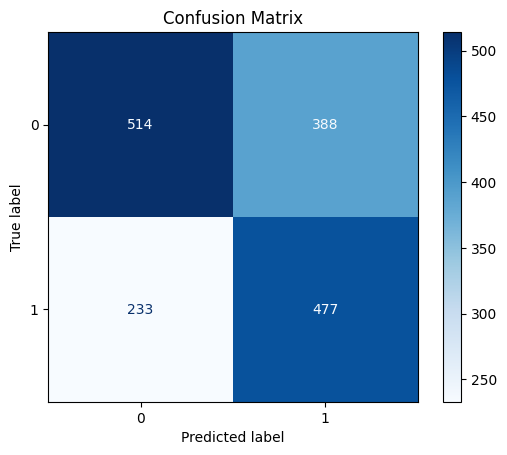

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

- Bilinmiyor sınıfı yatırıma uygun ve yatırıma uygun değil değerlerini içerdiğinden hatalı sınıflandırmalara sebep oldu.

In [334]:
with open("models/eligibility_model.pkl", "wb") as f:
    pickle.dump({
        "model": final_model,
        "columns": X.columns.tolist()
    }, f)

# 6-Sonuç ve Değerlendirme

## 6.1 Modellerin Analizi

| **Model Türü**                    | **Kullanılan Yöntem**     | **Güçlü Yönler**                                                            | **Zayıf Yönler**                                                             |
|----------------------------------|----------------------------|-----------------------------------------------------------------------------|------------------------------------------------------------------------------|
| **Fiyat Tahmin Modeli**          | XGBoost Regressor          | ✅ Yüksek R² skoru (0.81)  <br> ✅ Hızlı tahmin <br> ✅ Kapsamlı hiperparametre ayarı | ⚠️ MAE ve MSE bazı uç örneklerde yüksek <br> ⚠️ Veri dağılımı dengesizliği   |
| **Anomali Tespiti**              | Isolation Forest           | ✅ Etiketlenmemiş veride çalışabilir <br> ✅ Hızlı <br> ✅ Denetimsiz yapı     | ⚠️ Tespit edilen anomalilerin yorumu domain bilgisi gerektiriyor             |
| **Kümeleme (Ev Tipi Belirleme)** | KMeans                     | ✅ Anlamlı segmentasyon <br> ✅ PCA ile görselleştirilebilir <br> ✅ Kullanıcıya yorum sunar | ⚠️ Küme yorumlaması domain uzmanlığı gerektiriyor                 |
| **Yatırım Uygunluk Sınıflaması** | RidgeClassifier            | ✅ Düşük işlem süresi <br> ✅ Yorumlanabilir sonuçlar                         | ⚠️ Dengesiz sınıflar → doğruluk ve F1 (≈ 0.61) sınırlı                        |


## 6.2-Geliştirilebilir Yönler

* ✅ **API ile Gerçek Zamanlı Veri Kullanımı:** Verileri statik dosya yerine güncel emlak API'lerinden çekmek, modeli canlı veriyle besleyerek doğruluğu ve geçerliliği artırabilri.

* 🌍 **İstanbul Dışı Şehirlerin Eklenmesi:** Modeli diğer büyük şehirlerle (Ankara, İzmir vb.) genişletmek, ölçeklenebilirliği artıracaktır.

* ⚖️ **SMOTE ile Sınıf Dengesizliğinin Giderilmesi:** Yatırım uygunluğu sınıflandırmasında dengesiz veri yapısını dengeleyerek modelin başarımını artırabilir.

* 🏷️ **Anomali Tespitinde Etiketli Veri Kullanımı:** Denetimli anomali tespit yöntemleri ile doğruluk artırılabilir.

* 📦 **Model Versiyonlama ve MLflow Entegrasyonu:** Modellerin sürümlerini takip etmek ve deneyleri sistematik şekilde kaydetmek için MLflow gibi araçlar entegre edilebilir.

# 7-🔗 Linkler

Bu makine öğrenmesi modelleri kullanılarak geliştirilen, LLM Agent tabanlı Streamlit UI projesine aşağıdaki *`Proje Deposu`* linkinden erişebilirsiniz.


| İçerik                       | Bağlantı                                                                                     |
| ---------------------------- | -------------------------------------------------------------------------------------------- |
| 📂 Proje Deposu              | [GitHub – RealEstatAI](https://github.com/MuhammetAliVarlik/RealEstateAI)                |
| 🏦 Kaggle Linki             | [Kaggle – Istanbu Real Estate Ml Models](https://www.kaggle.com/code/muhammetalivarlik/istanbul-real-estate-ml-models)                |
| 📊 Kullanılan Veri Seti      | [Kaggle – House Price Dataset](https://www.kaggle.com/datasets/aselasel/house-price-dataset) |